## **Land usage classification in Agriculture**

### Introduction

Determining how land is used is a huge problem today. After all, its improper and illegal use can lead to both economic and natural disasters. One of the ways to assess the use is the analysis of aerial and satellite images of the earth's surface. A big problem is to build a mathematical model that can determine the type of land use based on colors. If you have ready-made photos and masks of land use, you can use the methods of artificial intelligence and big data to build a model-classifier.

We will learn how to upload photos, transform pixels and colors into a data set. Then we will learn how to build a classifier and predict land use masks based on it.


### Materials and methods

We will learn the basic methods of images transformation classification. The laboratory consists of four stages:
* Download and visualization of images
* DataSet creation
* Classification model creation
* Create your own mask of land use

The statistical data was obtained from https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery under [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01) license.


### Prerequisites
* [Python](https://www.python.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01) - basic level
* [numpy](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01) - middle level
* [SeaBorn](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01) - basic level
* [Matplotlib](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01) - basic level
* [scikit-learn](https://scikit-learn.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01) - middle level
* [pandas](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01) - basic level


### Objectives

* Download and transform images.
* Create a DataSet of the colors of images.
* Build a classification model.
* Build land use masks based on a classifier.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import json
from PIL import Image
from colormap import rgb2hex, hex2rgb
import skillsnetwork

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/data-science-in-agriculture-land-use-classification/Semantic_segmentation_dataset.zip", overwrite=True)

  0%|          | 0/333 [00:00<?, ?it/s]

Saved to '.'


In [3]:
def get_data(folder, file):
    f = open(folder + "/" + file,)
    data = json.load(f)
    f.close
    cl = {}
    
    for i,c in enumerate(data['classes']):
        c[i] = dict(c)
    
    for k,v in cl.items():
        print('Class' , k)
        for k2, v2 in v.items():
            print(" ", k2, v2)
    data = []
    
    sd = [item for item in os.listdir(folder) if os.path.isdir(folder + '/' + item)]
    print("Subdirectories : ", sd)
    for f in sd [1:2]:
        print ("Downloading : ", f)
        images = glob(folder + "/" + f + "/images" + "/*.jpg")
        for im in images :
            mask_f = im.replace("images" , "masks").replace("jpg", "png")
            image = Image.open(im)
            mask = Image.open(mask_f)
            if len(np.array(mask).shape) > 2:
                data.append([image, mask])
                
        fig = plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask)
        plt.show()
    
    return (data) 

Subdirectories :  ['Tile 8', 'Tile 1', 'Tile 6', 'Tile 7', 'Tile 5', 'Tile 2', 'Tile 3', 'Tile 4']


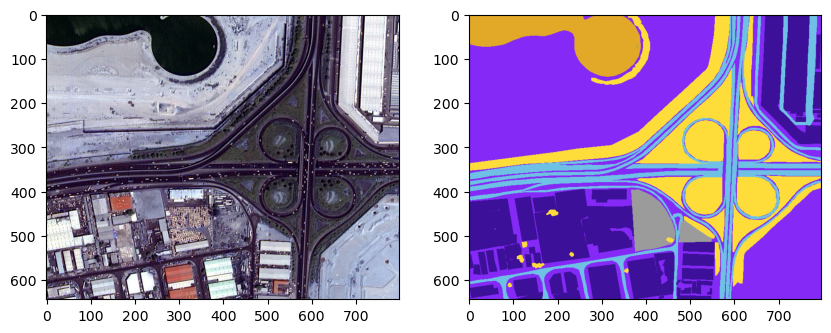

In [4]:
d = "Semantic segmentation dataset"
f = "classes.json"
data = get_data(d, f)

* As you can see, the csv file contains a description of 6 land use classes. 

* Each class has its own color in the mask file.
* We downloaded all the pictures and their masks from a separate directory and formed a set of data lists consisting of tuples of picture-mask.


In [5]:
len(data)

9

As you can see, we dowloaded 9 images.
Let's use first 4 images and masks for training and last 5 - for tests.

Let's make a function that will create a DataSet.

Each image is a set of points. Each point is represented by a tuple of RGB (red, green, blue). Every color is a number [0-1) for float or [0, 255) for int. 
Therefore, every image is a 3D array (height, width, color). Or a 2D array for gray scale.

To establish the dependence of color -> land use class, we need to convert each image into a dataset of the form (r, g, b) -> class.

To do this, we need to transform the image into a color matrix **[np.asarray()](https://numpy.org/doc/stable/reference/generated/numpy.asarray.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01)**, and then transform it into a one-dimensional form **[np.flatten()](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01)**.
To construct the output field, we need to additionally convert the color tuple (r, g, b) from the mask file into hex format: **[rgb2hex()](https://pythonhosted.org/colormap/references.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01)**.


In [6]:
def create_DataSet(data):
    DS = pd.DataFrame()
    for image, mask in data:
        im = np.asarray(image)
        mk = np.asarray(mask)
        
        im_red = im[:,:,0].flatten()
        im_green = im[:,:,1].flatten()
        im_blue = im[:,:,2].flatten()
        
        mk_red = mk[:,:,0].flatten()
        mk_green = mk[:,:,1].flatten()
        mk_blue = mk[:,:,2].flatten()
        
        h = np.array([rgb2hex(r, g, b) for r, g, b in zip(mk_red, mk_green, mk_blue)])
        d = np.array([im_red, im_green, im_blue, mk_red, mk_green, mk_blue, h])
        
        DS_new = pd.DataFrame(np.transpose(d), columns = ['Im_Red' , 'Im_Green', 'Im_Blue', 'Mk_Red', 'Mk_Green', 'Mk_Blue', 'HEX'])
        if len(DS) == 0:
            DS = DS_new
        else :
            DS = pd.concat([DS, DS_new], ignore_index=True)
    return DS

In [7]:
print("Create a training DataSet")
train = create_DataSet(data[:4])
print (train)
print ("_________________________________________________________________")
print("Create a test DataSet")
test = create_DataSet(data[:4])
print (test)

Create a training DataSet
        Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0          210      205     209    132       41     246  #8429F6
1          211      206     210    132       41     246  #8429F6
2          198      193     197    132       41     246  #8429F6
3          221      216     220    132       41     246  #8429F6
4          201      196     200    132       41     246  #8429F6
...        ...      ...     ...    ...      ...     ...      ...
2050676     68       52      91    132       41     246  #8429F6
2050677     33       19      54    132       41     246  #8429F6
2050678     96       87     108    132       41     246  #8429F6
2050679    109      104     110    132       41     246  #8429F6
2050680     95       96      90    132       41     246  #8429F6

[2050681 rows x 7 columns]
_________________________________________________________________
Create a test DataSet
        Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0          21

In [8]:
train.info()
print ("_________________________________________________________________")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050681 entries, 0 to 2050680
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    object
 1   Im_Green  object
 2   Im_Blue   object
 3   Mk_Red    object
 4   Mk_Green  object
 5   Mk_Blue   object
 6   HEX       object
dtypes: object(7)
memory usage: 109.5+ MB
_________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050681 entries, 0 to 2050680
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    object
 1   Im_Green  object
 2   Im_Blue   object
 3   Mk_Red    object
 4   Mk_Green  object
 5   Mk_Blue   object
 6   HEX       object
dtypes: object(7)
memory usage: 109.5+ MB


In [9]:
train.loc[:, 'HEX'] = train['HEX'].astype('category')
train['HEX']

0          #8429F6
1          #8429F6
2          #8429F6
3          #8429F6
4          #8429F6
            ...   
2050676    #8429F6
2050677    #8429F6
2050678    #8429F6
2050679    #8429F6
2050680    #8429F6
Name: HEX, Length: 2050681, dtype: object

In [10]:
test.loc[:, 'HEX'] = test['HEX'].astype('category')
test['HEX']

0          #8429F6
1          #8429F6
2          #8429F6
3          #8429F6
4          #8429F6
            ...   
2050676    #8429F6
2050677    #8429F6
2050678    #8429F6
2050679    #8429F6
2050680    #8429F6
Name: HEX, Length: 2050681, dtype: object

In [11]:
cl = ['Im_Red' , 'Im_Green', 'Im_Blue', 'Mk_Red', 'Mk_Green', 'Mk_Blue']
train[cl] = train[cl].astype('int64')
test[cl] = test[cl].astype('int64')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050681 entries, 0 to 2050680
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    int64 
 1   Im_Green  int64 
 2   Im_Blue   int64 
 3   Mk_Red    int64 
 4   Mk_Green  int64 
 5   Mk_Blue   int64 
 6   HEX       object
dtypes: int64(6), object(1)
memory usage: 109.5+ MB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050681 entries, 0 to 2050680
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    int64 
 1   Im_Green  int64 
 2   Im_Blue   int64 
 3   Mk_Red    int64 
 4   Mk_Green  int64 
 5   Mk_Blue   int64 
 6   HEX       object
dtypes: int64(6), object(1)
memory usage: 109.5+ MB


* Let’s visualize our data and see what exactly we are working with. 
* We use seaborn to plot the number of pixel classes and you can see what the output looks like.

<Axes: xlabel='HEX', ylabel='count'>

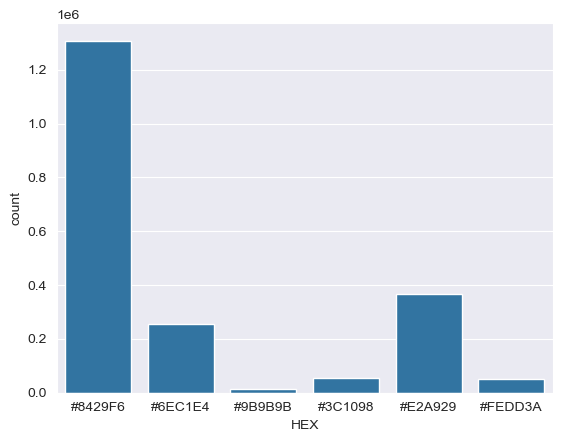

In [14]:
c = pd.DataFrame(train['HEX'])
sns.set_style('darkgrid')
sns.countplot(x = "HEX", data=c)

<Axes: xlabel='HEX', ylabel='count'>

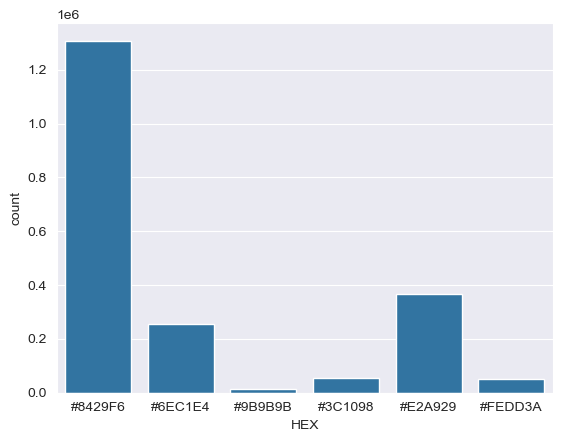

In [15]:
c = pd.DataFrame(test['HEX'])
sns.set_style('darkgrid')
sns.countplot(x = "HEX", data=c)

We will use **[sklearn.linear_model.LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01)** classifier for mask analysis. It is a very fast and simple classifier. 

We will use first 3 columns (RGB of image pixel) as imput parameters, and the last column (HEX color of mask picture) as an output.

The **[fit()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01&highlight=logisticregression#sklearn.linear_model.LogisticRegression.fit)** and **[score()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.score)** functions are used for training and evaluating the accuracy.

and finally we will use function **[ConfusionMatrixDisplay.from_estimator()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)** for analysis.


In [16]:
clf = LogisticRegression(max_iter=100, n_jobs= -1)
c = train.columns
clf.fit(train[c[0:3]], train[c[-1:]].values.ravel())

/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [17]:
scores_train = clf.score(train[c[0:3]], train[c[-1:]].values.ravel())
scores_test = clf.score(test[c[0:3]], test[c[-1:]].values.ravel())

Accuracy train Dataset :  82.4% Accuracy test DataSet:  82.4%


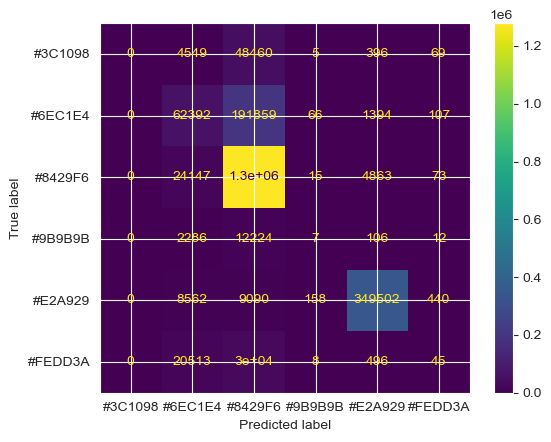

In [18]:
print('Accuracy train Dataset : {: .1%}'.format(scores_train), 'Accuracy test DataSet: {: .1%}'.format(scores_test))
ConfusionMatrixDisplay.from_estimator(clf, test[c[0:3]], test[c[-1:]].values.ravel())

# Creating own mask of land use

Let's build our own mask based on our classifier model.

First of all, you need to choose a few images from the downloaded data list and build your DataSet.


In [19]:
test_image = 8

mask_test = data[test_image : test_image+1]
mask_test_DataSet = create_DataSet(mask_test)

print (mask_test_DataSet)

       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0           5       14      11    226      169      41  #E2A929
1           9       18      15    226      169      41  #E2A929
2           1       10       7    226      169      41  #E2A929
3           5       14      11    226      169      41  #E2A929
4           8       17      14    226      169      41  #E2A929
...       ...      ...     ...    ...      ...     ...      ...
513263    183      197     226    132       41     246  #8429F6
513264    189      203     232    132       41     246  #8429F6
513265    191      205     234    132       41     246  #8429F6
513266    186      201     230    132       41     246  #8429F6
513267    181      196     225    132       41     246  #8429F6

[513268 rows x 7 columns]


In [20]:
c = mask_test_DataSet.columns
mask_test_predict = clf.predict(mask_test_DataSet[c[0:3]])
print(mask_test_predict)


['#E2A929' '#E2A929' '#E2A929' ... '#8429F6' '#8429F6' '#8429F6']


Further, we need to transform the 1D array of colors into a 2D matrix of Hex color using **[numpy.reshape()](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01)**. 


In [21]:
size = mask_test[0][1].size
print(size)

(797, 644)


In [22]:
predict_img = np.array(mask_test_predict).reshape((size[1], size[0]))
print(predict_img)

[['#E2A929' '#E2A929' '#E2A929' ... '#6EC1E4' '#8429F6' '#8429F6']
 ['#E2A929' '#E2A929' '#E2A929' ... '#6EC1E4' '#8429F6' '#8429F6']
 ['#E2A929' '#E2A929' '#E2A929' ... '#6EC1E4' '#8429F6' '#8429F6']
 ...
 ['#6EC1E4' '#6EC1E4' '#6EC1E4' ... '#8429F6' '#8429F6' '#8429F6']
 ['#6EC1E4' '#6EC1E4' '#6EC1E4' ... '#8429F6' '#8429F6' '#8429F6']
 ['#6EC1E4' '#6EC1E4' '#6EC1E4' ... '#8429F6' '#8429F6' '#8429F6']]


In [23]:
rgb_size = np.array(mask_test[0][0]).shape
print("Image size: ", rgb_size)
predict_img_rgb = np.zeros(rgb_size)
for i,r in enumerate(predict_img):
    for j,c in enumerate(r):
        predict_img_rgb[i, j, 0], predict_img_rgb[i, j, 1], predict_img_rgb[i, j, 2] = hex2rgb(c)

Image size:  (644, 797, 3)


Model mask


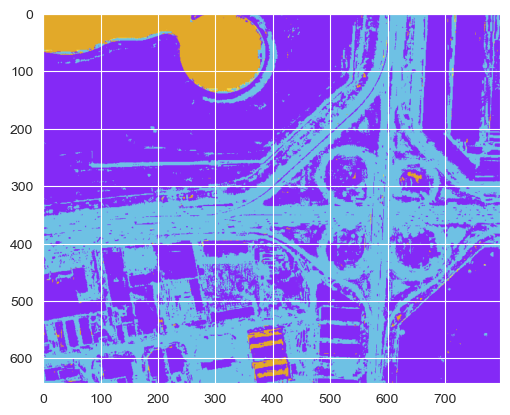

Real Mask


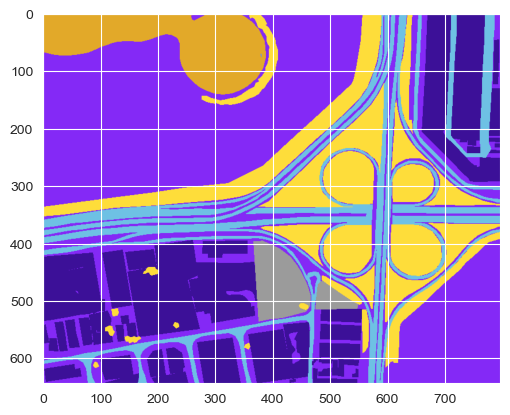

In [24]:
predict_img_rgb = predict_img_rgb.astype('int')
print("Model mask")

plt.imshow(predict_img_rgb)
plt.show()
print("Real Mask")

plt.imshow(mask_test[0][1])
plt.show()

## Get your own Image mask 

Insert the file path of your own image and get your own predicted mask for an image

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


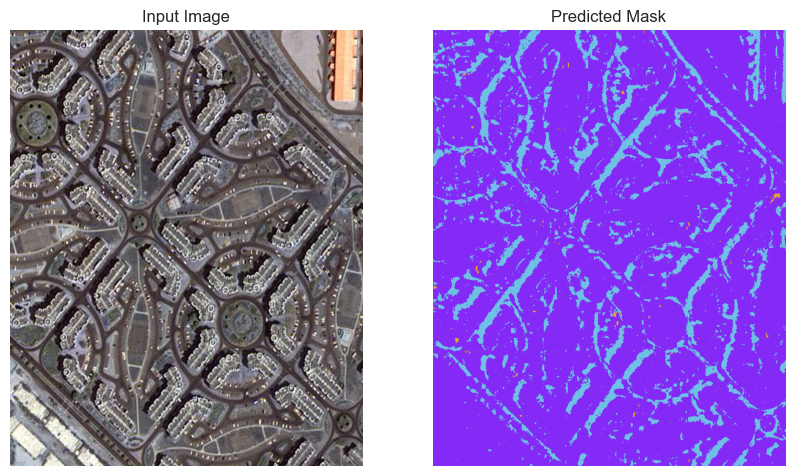

In [ ]:
def preprocess_image(img, target_size):
    img = img.resize(target_size)
    img_array = np.array(img)
    return img_array

def predict_mask(img_array, clf):
    h, w, _ = img_array.shape
    pixels = img_array.reshape(-1, 3)
    pred_hex = clf.predict(pixels)
    pred_rgb = np.array([hex2rgb(hx) for hx in pred_hex]).reshape(h, w, 3)
    return pred_rgb.astype('uint8')

# Change this to your image file path
image_path = ' '

if os.path.exists(image_path):
    img = Image.open(image_path).convert('RGB')
    target_size = rgb_size[:2] if 'rgb_size' in globals() else img.size
    img_array = preprocess_image(img, target_size)
    if 'clf' in globals():
        pred_mask = predict_mask(img_array, clf)
    else:
        pred_mask = np.zeros_like(img_array)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    
    plt.title('Input Image')
    plt.imshow(img_array)
    plt.axis('off')
    plt.subplot(1,2,2)
    
    plt.title('Predicted Mask')
    plt.imshow(pred_mask)
    plt.axis('off')
    plt.show()
else:
    print(f"File not found: {image_path}")